In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import h5py
import sys
import os
import glob
import warnings
import matplotlib.pyplot as plt

from tqdm import tqdm

warnings.filterwarnings('ignore')

import torch
if torch.cuda.is_available():
    device = torch.device('cuda:0')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print('Using device: ', device)

Using device:  mps


# Fly closed loop

Initializing
Using torchdiffeq solver


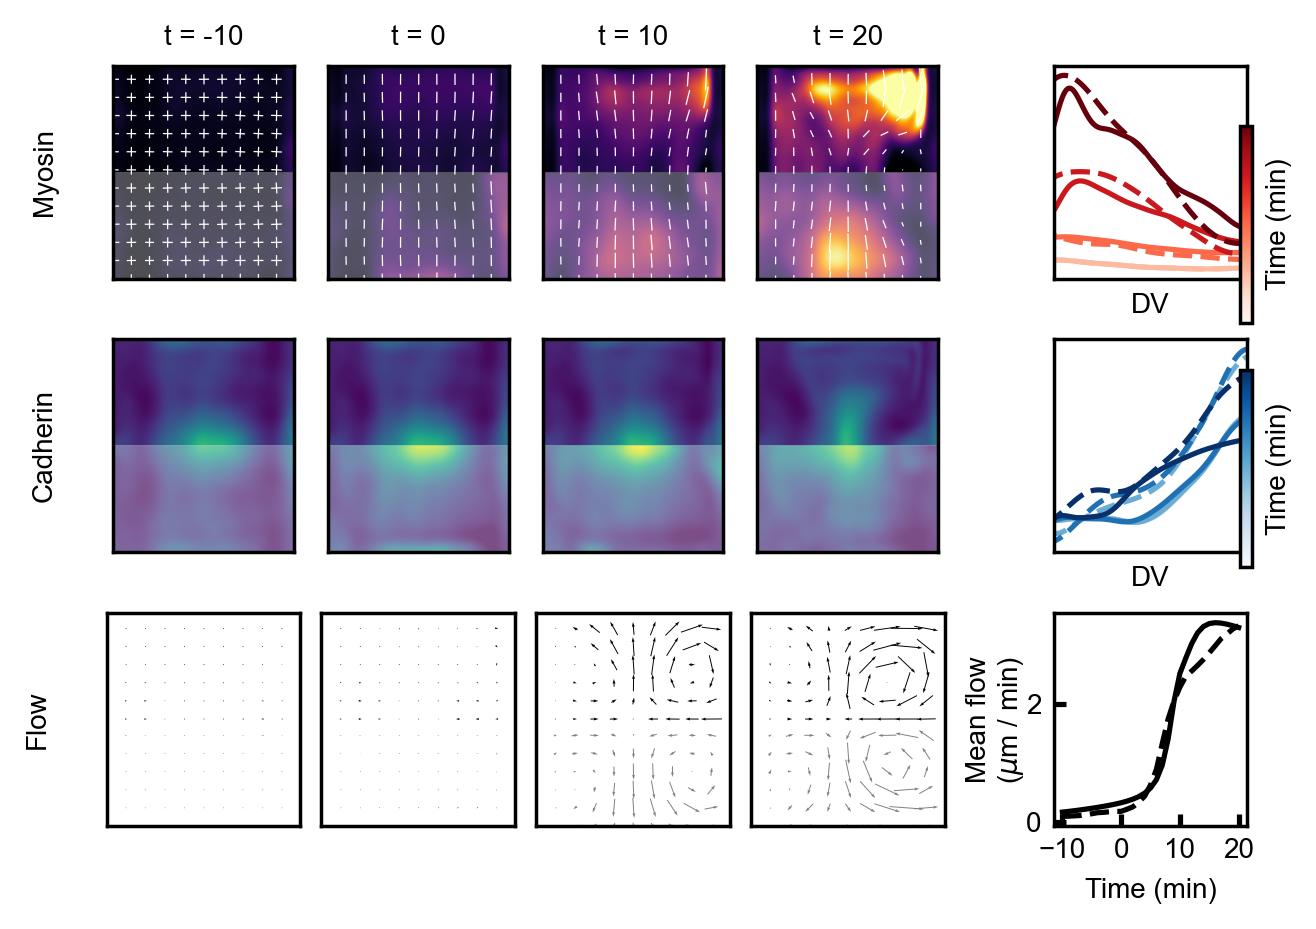

In [6]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from morphogenesis.flow_networks.translation_models import VAE, MaskedVAE
from morphogenesis.forecasting.closed_loop import ClosedFlyLoop
from morphogenesis.forecasting.plot_utils import *

from scipy.interpolate import interp1d
from pprint import pprint

# Collect model
vae = MaskedVAE(in_channels=4, 
                  out_channels=2, 
                  num_latent=64, 
                  stage_dims=[[32,32], [64,64], [128,128], [256,256]])
info = torch.load('../04.TranslationNetworks/tb_logs/MaskedVAE_sqh_beta=0.0001_split=embryo', map_location='cpu')
vae.load_state_dict(info['state_dict'])
vae.to(device).eval()
pprint(info['hparams'])

def v_model(t, y):
    y = y.reshape([-1, 5, 236, 200])[:, :4]
    return VAE.forward(vae, y)[0]

#Collect initial conditions - m, c, v, and time
with h5py.File('../02.LearnDynamicsModel/myosin_fitting.h5', 'r') as h5f:
    data = h5f['ensemble']
    tmin, tmax = -10, 20
    
    t = data['fields/v'].attrs['t']
    t_mask = np.logical_and(t >= tmin, t <= tmax)
    m0 = data['fields/m_ij'][t_mask, ...][()]
    s0 = data['fields/c'][t_mask, ...][()]
    v0 = data['fields/v'][t_mask, ...][()]
    t0 = t[t_mask, ...][()]
    
y0 = np.concatenate([
    m0[0].reshape([4, *m0.shape[-2:]]),
    s0[0].reshape([1, *s0.shape[-2:]]),
])
y0 = torch.FloatTensor(y0)
model = ClosedFlyLoop(v_model, sigma=3)
model.fit(y0[None])
model.float()

m, s, v = model.integrate(y0.to(device), t0)

comparison_plot(
    t0,
    ('Myosin', m, m0),
    ('Cadherin', s, s0),
    ('Flow', v, v0),
    dt=10)